<a href="https://colab.research.google.com/github/sumamaddu/major/blob/main/6th_feb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
GPU detected. Using tensorflow-gpu.
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Found 1447 files belonging to 2 classes.
Using 1158 files for training.
Found 1447 files belonging to 2 classes.
Using 289 files for validation.
Found 209 files belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Mixed precision training enabled.
Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5724 - loss: 1.0030
Epoch 1: val_accuracy improved from -inf to 0.57093, saving model to /content/drive/MyDrive/model/os

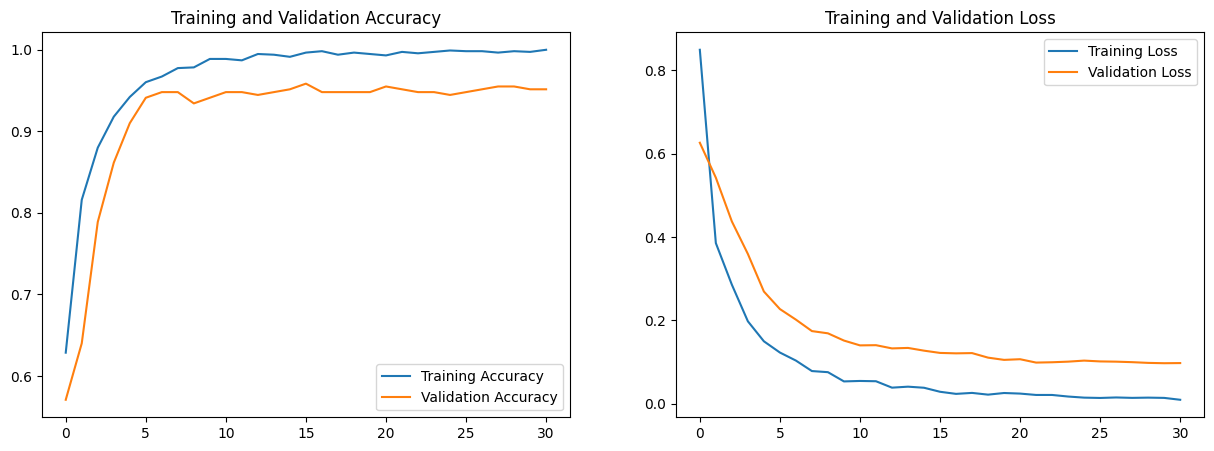

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


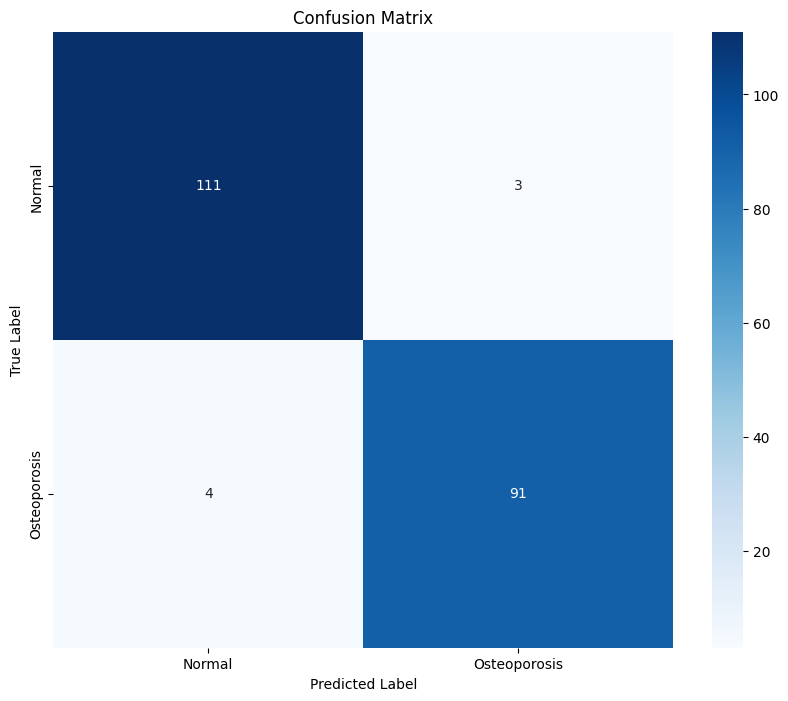

Classification Report:
               precision    recall  f1-score   support

      Normal       0.97      0.97      0.97       114
Osteoporosis       0.97      0.96      0.96        95

    accuracy                           0.97       209
   macro avg       0.97      0.97      0.97       209
weighted avg       0.97      0.97      0.97       209



In [2]:
 # Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required libraries (installing tensorflow-gpu if available)
try:
    import tensorflow as tf
    # Check for GPU availability
    if len(tf.config.list_physical_devices('GPU')) > 0:
        print("GPU detected. Using tensorflow-gpu.")
        !pip install tensorflow-gpu scikit-learn matplotlib
    else:
        print("No GPU detected. Using regular tensorflow.")
        !pip install tensorflow scikit-learn matplotlib
except:
    print("Error with tensorflow. Using regular tensorflow.")
    !pip install tensorflow scikit-learn matplotlib

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Data and model parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32 # You can try 64 if your GPU has enough memory
EPOCHS = 50

# Corrected Data Paths
TRAIN_DIR = "/content/drive/MyDrive/Final_ds-20241211T160515Z-001/Final_ds/train"
TEST_DIR = "/content/drive/MyDrive/Final_ds-20241211T160515Z-001/Final_ds/test"
MODEL_DIR = "/content/drive/MyDrive/model"

os.makedirs(MODEL_DIR, exist_ok=True)

# --- Optimized Data Loading using tf.data ---
def preprocess_image(image, label):
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0  # Rescale
    return image, label

train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='training',
    seed=42
)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='validation',
    seed=42
)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False # No need to shuffle test data
)

# Get class names before applying prefetch
class_names = train_dataset.class_names  # Store class names here

AUTOTUNE = tf.data.AUTOTUNE #Use AUTOTUNE for optimal performance
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)

# --- End of Optimized Data Loading ---

# VGG16 with FNN (Improved Architecture)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  # Reduced Dense layer size
x = BatchNormalization()(x)  # Added Batch Normalization
x = Dropout(0.5)(x)
num_classes = len(class_names)  # Access class_names here
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# --- Mixed Precision Training (if GPU is available) ---
try:
    # Enable mixed precision training
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision training enabled.")
except Exception as e:
    print(f"Could not enable mixed precision: {e}")

# --- End of Mixed Precision Training ---

# Compile
opt = Adam(learning_rate=0.00001)  # Lowered learning rate further
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks (Improved Callbacks)
checkpoint_path = os.path.join(MODEL_DIR, "osteoporosis_model.keras")
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)

# Train (using tf.data datasets)
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=[checkpoint, early, reduce_lr]
)

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Save class names
np.save(os.path.join(MODEL_DIR, "class_names.npy"), class_names)

# Plot Training History
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get true labels and predicted labels
true_labels = []
pred_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)  # Get predictions
    pred_labels.extend(np.argmax(preds, axis=1))  # Convert to class index
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert to class index

# Compute Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:\n", classification_report(true_labels, pred_labels, target_names=class_names))
